In [1]:
import numpy             as np
import scipy             as sp
import matplotlib.pyplot as plt
import time
from numba import njit

from tqdm            import tqdm
from scipy           import signal

from propagation import received_power, quad_distribute_power, propagation_delay, gen_qrx_onlyclocked

from parametermeasurement import generate_clocks, measure_range_roberts, measure_bearing

from positioning import classicalfix_directbearing_mle, classicalfix_diffbearing_mle, \
                        classicalfix_directrange_mle, classicalfix_diffrange_mle, \
                        runningfix_directbearing_mle, runningfix_directrange_mle

from simulation import Simulation, generate_simulation_clocks

### Set common simulation configurations

In [2]:
iterations = 1000

### world parameters
sim = Simulation(weather        = "clear", 
                 temperature    = 298,   # [K], circuit temperature
                 daynight       = "day_indirectsun", 
                 rxconfig       = "optics/qrx_planoconvex.npz", 
                 txconfig       = "optics/tx_lambertian_20deg_2W.npz", 
                 istxlambertian = True, 
                 f_adc_clk      = 1.0e7,  # [Hz] ADC measurement clock freq
                 f_e            = 1.0e6,  # [Hz] emitted wave freq, left TX
                 f_sim          = 1.0e10) # [Hz] simulation master clock freq

L_ego    = 1.6 # [m]
L_target = 1.5 # [m] arbitrary selection, just to make it different than the ego. This is not known, so it's not used in the algo

### build heatmap coordinates similar to TVT article
x_num_points = 10
xRL_to_rxL   = np.linspace(-3 + L_ego/2, 3 + L_ego/2, x_num_points) # SM4 from TVT
y_num_points = int(np.round(x_num_points*2.333333))
yRL_to_rxL   = np.linspace(1, 15, y_num_points) # SM4 from TVT
xRL_to_rxR   = xRL_to_rxL - L_ego
yRL_to_rxR   = yRL_to_rxL
xRR_to_rxL   = xRL_to_rxL + L_target
yRR_to_rxL   = yRL_to_rxL
xRR_to_rxR   = xRL_to_rxL + L_target - L_ego
yRR_to_rxR   = yRL_to_rxL

# simulation for each heat map point takes 1 vlp cycle
vlp_rate    = 100
t_sim_stop  = 1/vlp_rate
s_adc_clock = generate_simulation_clocks(t_sim_stop, sim.f_simulation, sim.f_adc_clock, gen_clocked_only=True)

f_vehicle   = 1e3; # [Hz], trajectory simulation clock rate, fixed by trajectory generation
s_veh_clock = generate_simulation_clocks(t_sim_stop, sim.f_simulation, f_vehicle, gen_clocked_only=True)

### Define full simulation run as a function

In [3]:
def simrun(xRL_to_rxL, yRL_to_rxL, xRL_to_rxR, yRL_to_rxR, 
           xRR_to_rxL, yRR_to_rxL, xRR_to_rxR, yRR_to_rxR,
           s_adc_clock, sim, iterations):
    ### simulate received power
    pwr_txL_to_rxL = received_power(xRL_to_rxL, yRL_to_rxL, np.zeros_like(yRL_to_rxL), np.zeros_like(yRL_to_rxL), sim)
    pwr_txL_to_rxR = received_power(xRL_to_rxR, yRL_to_rxR, np.zeros_like(yRL_to_rxR), np.zeros_like(yRL_to_rxL), sim)
    pwr_txR_to_rxL = received_power(xRR_to_rxL, yRR_to_rxL, np.zeros_like(yRR_to_rxL), np.zeros_like(yRL_to_rxL), sim)
    pwr_txR_to_rxR = received_power(xRR_to_rxR, yRR_to_rxR, np.zeros_like(yRR_to_rxR), np.zeros_like(yRL_to_rxL), sim)
    
    shared_pwr_txL_to_rxL = quad_distribute_power(xRL_to_rxL, yRL_to_rxL, 0, sim.rx_config_bundle["f_QRX"], pwr_txL_to_rxL)
    shared_pwr_txL_to_rxR = quad_distribute_power(xRL_to_rxR, yRL_to_rxR, 0, sim.rx_config_bundle["f_QRX"], pwr_txL_to_rxR)
    shared_pwr_txR_to_rxL = quad_distribute_power(xRR_to_rxL, yRR_to_rxL, 0, sim.rx_config_bundle["f_QRX"], pwr_txR_to_rxL)
    shared_pwr_txR_to_rxR = quad_distribute_power(xRR_to_rxR, yRR_to_rxR, 0, sim.rx_config_bundle["f_QRX"], pwr_txR_to_rxR)
    
    delay_txL_to_rxL = propagation_delay(xRL_to_rxL, yRL_to_rxL, sim.lightspeed)
    delay_txL_to_rxR = propagation_delay(xRL_to_rxR, yRL_to_rxR, sim.lightspeed)
    delay_txR_to_rxL = propagation_delay(xRR_to_rxL, yRR_to_rxL, sim.lightspeed)
    delay_txR_to_rxR = propagation_delay(xRR_to_rxR, yRR_to_rxR, sim.lightspeed)
    
    ### run simulation over the list of points    
    cls_x_directbearing = np.zeros((iterations)); 
    cls_y_directrange   = np.zeros((iterations));
    
    for j in range(0,iterations):
        smp_lo = 0
        smp_hi = int(f_vehicle/vlp_rate)
        numticks = int(f_vehicle/vlp_rate)
        step_time       = s_veh_clock[smp_lo:smp_hi] 
        simulation_time = s_adc_clock[0:int(sim.f_adc_clock/f_vehicle)]

        rxLL, rxLR, rxRL, rxRR, delays = gen_qrx_onlyclocked(shared_pwr_txL_to_rxL, shared_pwr_txL_to_rxR, 
                                                             shared_pwr_txR_to_rxL, shared_pwr_txR_to_rxR,
                                                             delay_txL_to_rxL, delay_txL_to_rxR, 
                                                             delay_txR_to_rxL, delay_txR_to_rxR, sim, step_time, 
                                                             simulation_time, smp_lo, smp_hi);
        (rxLA_txL, rxLB_txL, rxLC_txL, rxLD_txL) = rxLL
        (rxLA_txR, rxLB_txR, rxLC_txR, rxLD_txR) = rxLR
        (rxRA_txL, rxRB_txL, rxRC_txL, rxRD_txL) = rxRL
        (rxRA_txR, rxRB_txR, rxRC_txR, rxRD_txR) = rxRR 
        (delayLL_sigTime, delayLR_sigTime, delayRL_sigTime, delayRR_sigTime) = delays

        del rxLL, rxLR, rxRL, rxRR, delays 

        # initial transmitted signal is known (mark the +, that's because the signal does a roundtrip
        # which is 1 delay earlier than echo transmission from target vehicle)
        wav_rxL_txL = np.sin(2*np.pi*sim.f_emitted*(simulation_time + delayLL_sigTime))
        wav_rxR_txL = np.sin(2*np.pi*sim.f_emitted*(simulation_time + delayLR_sigTime))

        d_rxL_txL = measure_range_roberts(rxLA_txL + rxLB_txL + rxLC_txL + rxLD_txL, wav_rxL_txL, sim.lightspeed, sim.f_emitted)
        d_rxR_txL = measure_range_roberts(rxRA_txL + rxRB_txL + rxRC_txL + rxRD_txL, wav_rxR_txL, sim.lightspeed, sim.f_emitted)

        thd = 1e-5; # just to avoid messing up the graphs when aoa detection is too bad.
        # assume that the VLC subsystem correctly decodes the signal (mark that the delayed signal 
        # is decoded, so the delay isn't actually measured, it's implicitly present on the RX signal)
        wav_rxL_txL = np.sin(2*np.pi*sim.f_emitted*(simulation_time - delayLL_sigTime))
        wav_rxR_txL = np.sin(2*np.pi*sim.f_emitted*(simulation_time - delayLR_sigTime))
        aoa_rxL_txL = measure_bearing(rxLA_txL, rxLB_txL, rxLC_txL, rxLD_txL, wav_rxL_txL, sim.rx_config_bundle["f_QRX"], thd)
        aoa_rxR_txL = measure_bearing(rxRA_txL, rxRB_txL, rxRC_txL, rxRD_txL, wav_rxR_txL, sim.rx_config_bundle["f_QRX"], thd)

        cls_x_directbearing[j], _ = classicalfix_directbearing_mle(aoa_rxL_txL, aoa_rxR_txL, L_ego)
        _, cls_y_directrange[j]   = classicalfix_directrange_mle(d_rxL_txL, d_rxR_txL, L_ego)

    return cls_x_directbearing, cls_y_directrange

In [4]:
error_heatmap = np.zeros((x_num_points, y_num_points, iterations))
for idx_x, _ in enumerate(tqdm(xRL_to_rxL)):
    for idx_y, _ in enumerate(yRL_to_rxL):
        xRL_to_rxL_rep = np.ones(( int(f_vehicle/vlp_rate) ))*xRL_to_rxL[idx_x]
        yRL_to_rxL_rep = np.ones(( int(f_vehicle/vlp_rate) ))*yRL_to_rxL[idx_y]
        xRL_to_rxR_rep = np.ones(( int(f_vehicle/vlp_rate) ))*xRL_to_rxR[idx_x]
        yRL_to_rxR_rep = np.ones(( int(f_vehicle/vlp_rate) ))*yRL_to_rxR[idx_y]
        xRR_to_rxL_rep = np.ones(( int(f_vehicle/vlp_rate) ))*xRR_to_rxL[idx_x]
        yRR_to_rxL_rep = np.ones(( int(f_vehicle/vlp_rate) ))*yRR_to_rxL[idx_y]
        xRR_to_rxR_rep = np.ones(( int(f_vehicle/vlp_rate) ))*xRR_to_rxR[idx_x]
        yRR_to_rxR_rep = np.ones(( int(f_vehicle/vlp_rate) ))*yRR_to_rxR[idx_y]
        x_est, y_est = simrun(xRL_to_rxL_rep, yRL_to_rxL_rep, xRL_to_rxR_rep, yRL_to_rxR_rep, 
                              xRR_to_rxL_rep, yRR_to_rxL_rep, xRR_to_rxR_rep, yRR_to_rxR_rep,
                              s_adc_clock, sim, iterations);
        error_heatmap[idx_x, idx_y, :] = np.sqrt((xRL_to_rxL[idx_x] - x_est)**2 + (yRL_to_rxL[idx_y] - y_est)**2)

  0%|                                                    | 0/10 [00:00<?, ?it/s]/home/ubuntu/vehicular-vlp-simulations/positioning.py:102: RuntimeWarning: invalid value encountered in scalar divide
  est_x = L*(1 + np.sin(np.deg2rad(aoaR))*np.cos(np.deg2rad(aoaL))/np.sin(np.deg2rad(aoaL - aoaR)));
/home/ubuntu/vehicular-vlp-simulations/positioning.py:103: RuntimeWarning: divide by zero encountered in scalar divide
  est_y = L*np.cos(np.deg2rad(aoaR))*np.cos(np.deg2rad(aoaL))/np.sin(np.deg2rad(aoaL - aoaR));
/home/ubuntu/vehicular-vlp-simulations/positioning.py:108: RuntimeWarning: invalid value encountered in sqrt
  est_y = np.sqrt(dL**2-est_x**2)
100%|██████████████████████████████████████████| 10/10 [17:30<00:00, 105.03s/it]


In [5]:
error_heatmap_mean = np.mean(error_heatmap,axis=-1)
error_heatmap_stdv = np.std(error_heatmap,axis=-1)

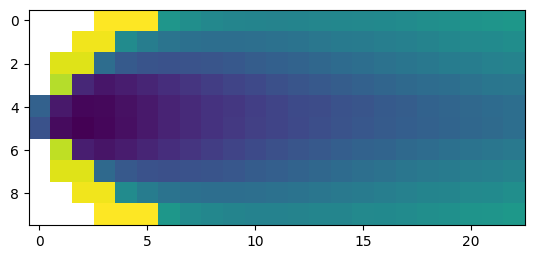

In [12]:
plt.imshow(np.log10(error_heatmap_mean))

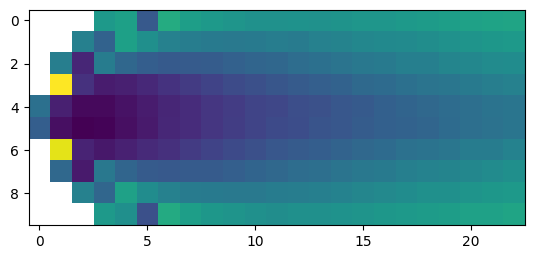

In [11]:
plt.imshow(np.log10(error_heatmap_stdv))